In [ ]:
#1.0.1 - 2025 - 07 - 01
#Dr. Marco Antonio Aceves
#rev en Jupyter Notebook
#Código como ejemplo como parte del libro:
#de 0 a 100 en Inteligencia Artificial
#Regularización


In [5]:
#Cargas librerías
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, validation_curve
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Configuración
np.random.seed(42)
plt.style.use('default')


In [7]:
print("=== PREDICCIÓN DE PRECIOS DE VIVIENDAS ===")
print("Demostración de Sobreajuste y Regularización\n")

#GENERACIÓN DE DATOS REALISTAS DE VIVIENDAS
def generate_housing_data(n_samples=200):
    """Genera datos sintéticos pero realistas de viviendas"""
    np.random.seed(42)
    
    # Características principales
    area = np.random.normal(150, 50, n_samples)  # m²
    bedrooms = np.random.poisson(3, n_samples) + 1  # 1-6 habitaciones
    bathrooms = np.random.poisson(2, n_samples) + 1  # 1-4 baños
    age = np.random.exponential(15, n_samples)  # años
    distance_center = np.random.exponential(8, n_samples)  # km
    
    # Características adicionales (algunas relevantes, otras no)
    garage = np.random.binomial(1, 0.7, n_samples)  # 0 o 1
    garden = np.random.binomial(1, 0.5, n_samples)  # 0 o 1
    floors = np.random.choice([1, 2, 3], n_samples, p=[0.4, 0.5, 0.1])
    
    # Características irrelevantes (ruido)
    house_number = np.random.randint(1, 9999, n_samples)
    street_width = np.random.normal(8, 2, n_samples)
    neighbor_cats = np.random.poisson(2, n_samples)
    
    # Función de precio realista
    price = (
        area * 2000 +  # €2000 por m²
        bedrooms * 15000 +  # €15000 por habitación
        bathrooms * 8000 +  # €8000 por baño
        -age * 1500 +  # Depreciación por año
        -distance_center * 5000 +  # Ubicación importa
        garage * 25000 +  # Garaje añade valor
        garden * 15000 +  # Jardín añade valor
        floors * 10000 +  # Más pisos, más valor
        100000  # Precio base
    )
    
    # Añadir ruido realista
    price += np.random.normal(0, 30000, n_samples)
    
    # Crear DataFrame
    data = pd.DataFrame({
        'area': area,
        'bedrooms': bedrooms,
        'bathrooms': bathrooms,
        'age': age,
        'distance_center': distance_center,
        'garage': garage,
        'garden': garden,
        'floors': floors,
        'house_number': house_number,  # Irrelevante
        'street_width': street_width,  # Irrelevante
        'neighbor_cats': neighbor_cats,  # Irrelevante
        'price': price
    })
    
    return data
    

=== PREDICCIÓN DE PRECIOS DE VIVIENDAS ===
Demostración de Sobreajuste y Regularización



In [8]:
# Generar datos
df = generate_housing_data(200)

print("Datos generados:")
print(f"- {len(df)} viviendas")
print(f"- {len(df.columns)-1} características")
print(f"- Precio promedio: €{df['price'].mean():,.0f}")
print(f"- Rango de precios: €{df['price'].min():,.0f} - €{df['price'].max():,.0f}")

# Mostrar correlaciones
print("\n=== CORRELACIONES CON EL PRECIO ===")
correlations = df.corr()['price'].sort_values(ascending=False)
print(correlations.round(3))


Datos generados:
- 200 viviendas
- 11 características
- Precio promedio: €454,840
- Rango de precios: €62,145 - €730,888

=== CORRELACIONES CON EL PRECIO ===
price              1.000
area               0.841
bedrooms           0.178
bathrooms          0.117
garage             0.115
garden             0.037
neighbor_cats      0.023
house_number       0.008
street_width      -0.004
floors            -0.063
age               -0.271
distance_center   -0.416
Name: price, dtype: float64



Datos divididos:
- Entrenamiento: 160 viviendas
- Test: 40 viviendas

=== DEMOSTRACIÓN DEL SOBREAJUSTE ===
Grado	Train MSE	Test MSE	Train R²	Test R²	Diferencia MSE
--------------------------------------------------------------------------------
1	630687339	680832748	0.952	0.939	50145409
2	381053298	1228343452	0.971	0.890	847290154
3	0	11663524979	1.000	-0.043	11663524979
4	0	4888929948	1.000	0.563	4888929948


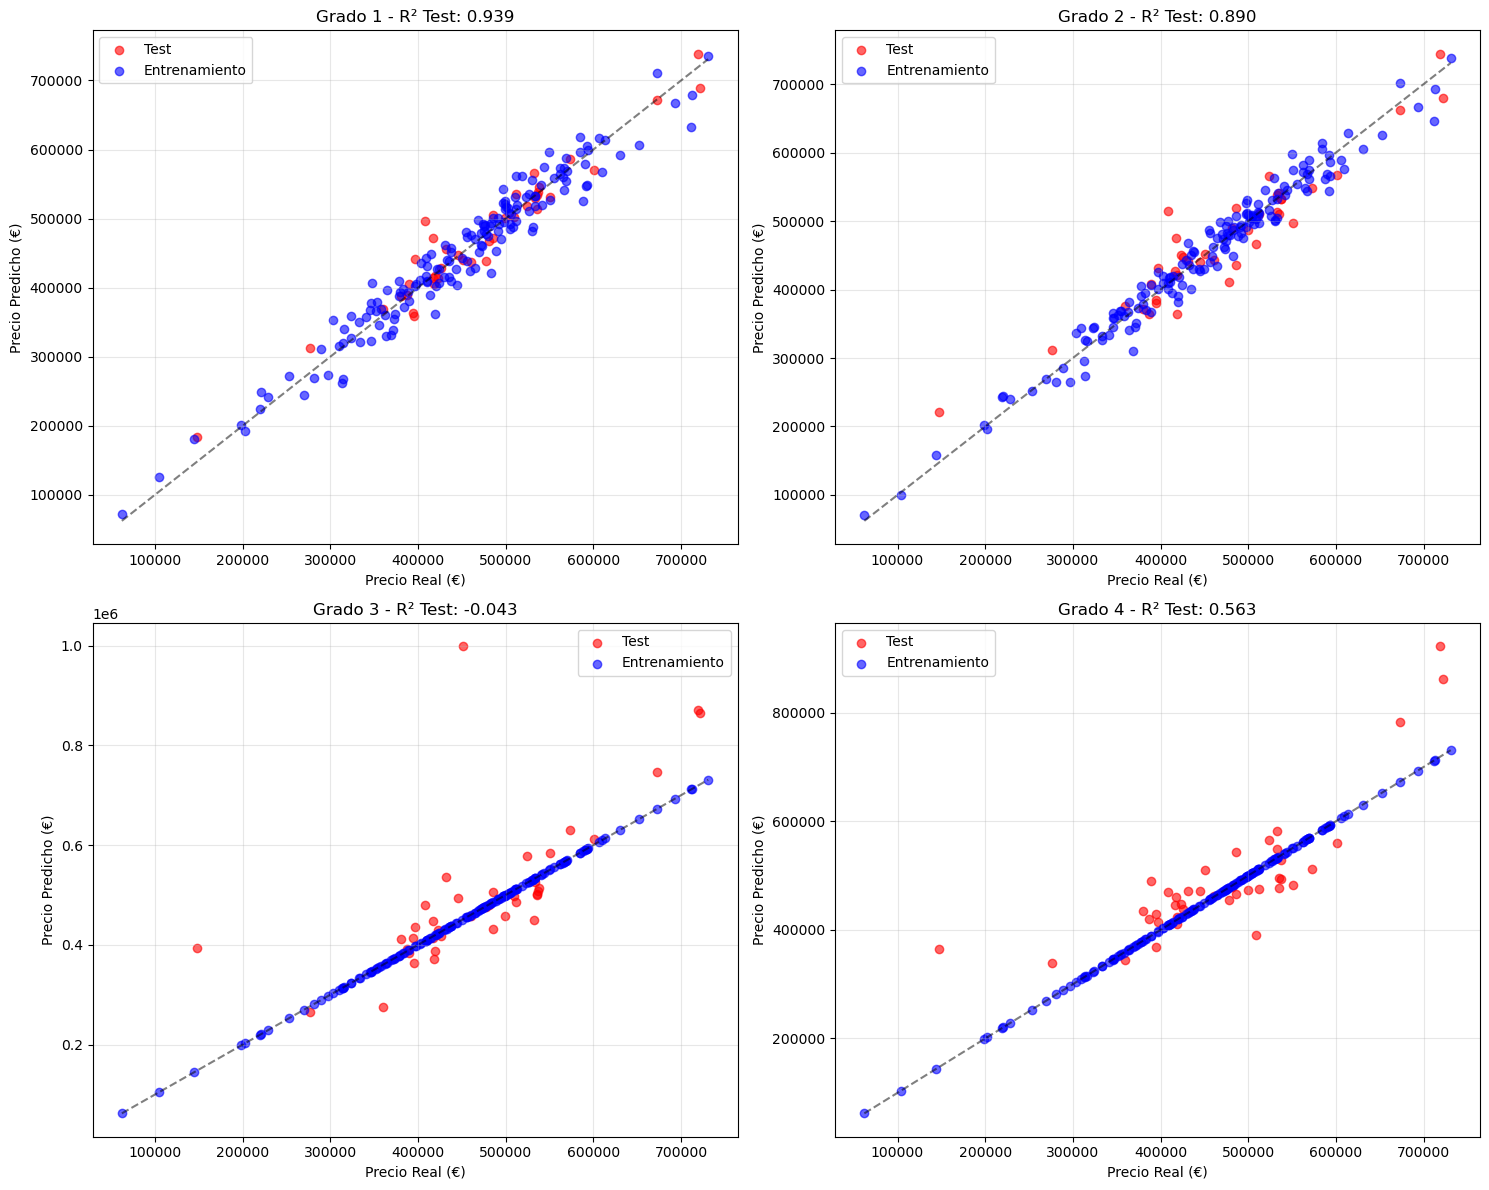

In [10]:
#PREPARACIÓN DE DATOS
X = df.drop('price', axis=1)
y = df['price']

# División estratificada
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Normalización
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nDatos divididos:")
print(f"- Entrenamiento: {len(X_train)} viviendas")
print(f"- Test: {len(X_test)} viviendas")

#DEMOSTRACIÓN DEL SOBREAJUSTE CON CARACTERÍSTICAS POLINOMIALES
print("\n=== DEMOSTRACIÓN DEL SOBREAJUSTE ===")

def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    """Evalúa un modelo y retorna métricas"""
    model.fit(X_train, y_train)
    
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    return {
        'model': model,
        'train_mse': train_mse,
        'test_mse': test_mse,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'y_train_pred': y_train_pred,
        'y_test_pred': y_test_pred
    }

# Probamos diferentes grados de complejidad
degrees = [1, 2, 3, 4]
results = {}

print("Grado\tTrain MSE\tTest MSE\tTrain R²\tTest R²\tDiferencia MSE")
print("-" * 80)

for degree in degrees:
    model = Pipeline([
        ('poly', PolynomialFeatures(degree=degree)),
        ('linear', LinearRegression())
    ])
    
    result = evaluate_model(model, X_train_scaled, y_train, X_test_scaled, y_test, f'Grado {degree}')
    results[degree] = result
    
    diff_mse = result['test_mse'] - result['train_mse']
    print(f"{degree}\t{result['train_mse']:.0f}\t{result['test_mse']:.0f}\t{result['train_r2']:.3f}\t{result['test_r2']:.3f}\t{diff_mse:.0f}")

#VISUALIZACIÓN DEL SOBREAJUSTE
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

for i, degree in enumerate(degrees):
    ax = axes[i]
    result = results[degree]
    
    # Scatter plot: predicción vs real
    ax.scatter(y_test, result['y_test_pred'], alpha=0.6, label='Test', color='red')
    ax.scatter(y_train, result['y_train_pred'], alpha=0.6, label='Entrenamiento', color='blue')
    
    # Línea perfecta
    min_price = min(y_train.min(), y_test.min())
    max_price = max(y_train.max(), y_test.max())
    ax.plot([min_price, max_price], [min_price, max_price], 'k--', alpha=0.5)
    
    ax.set_xlabel('Precio Real (€)')
    ax.set_ylabel('Precio Predicho (€)')
    ax.set_title(f'Grado {degree} - R² Test: {result["test_r2"]:.3f}')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



=== APLICACIÓN DE REGULARIZACIÓN ===
Usaremos el modelo de grado 4 (sobreajustado) y aplicaremos regularización
Características expandidas: 1365 (de 11 originales)

Alpha	Train MSE	Test MSE	Train R²	Test R²	Diferencia MSE
--------------------------------------------------------------------------------
0	0	4888929948	1.000	0.563	4888929948	SIN REG
0.1	1204	4906783529	1.000	0.561	4906782326	L2 REG
1	113750	4890667505	1.000	0.563	4890553756	L2 REG
10	7447625	4751183252	0.999	0.575	4743735627	L2 REG
100	175580860	4293280522	0.987	0.616	4117699662	L2 REG
1000	1402439273	5650719422	0.893	0.495	4248280149	L2 REG


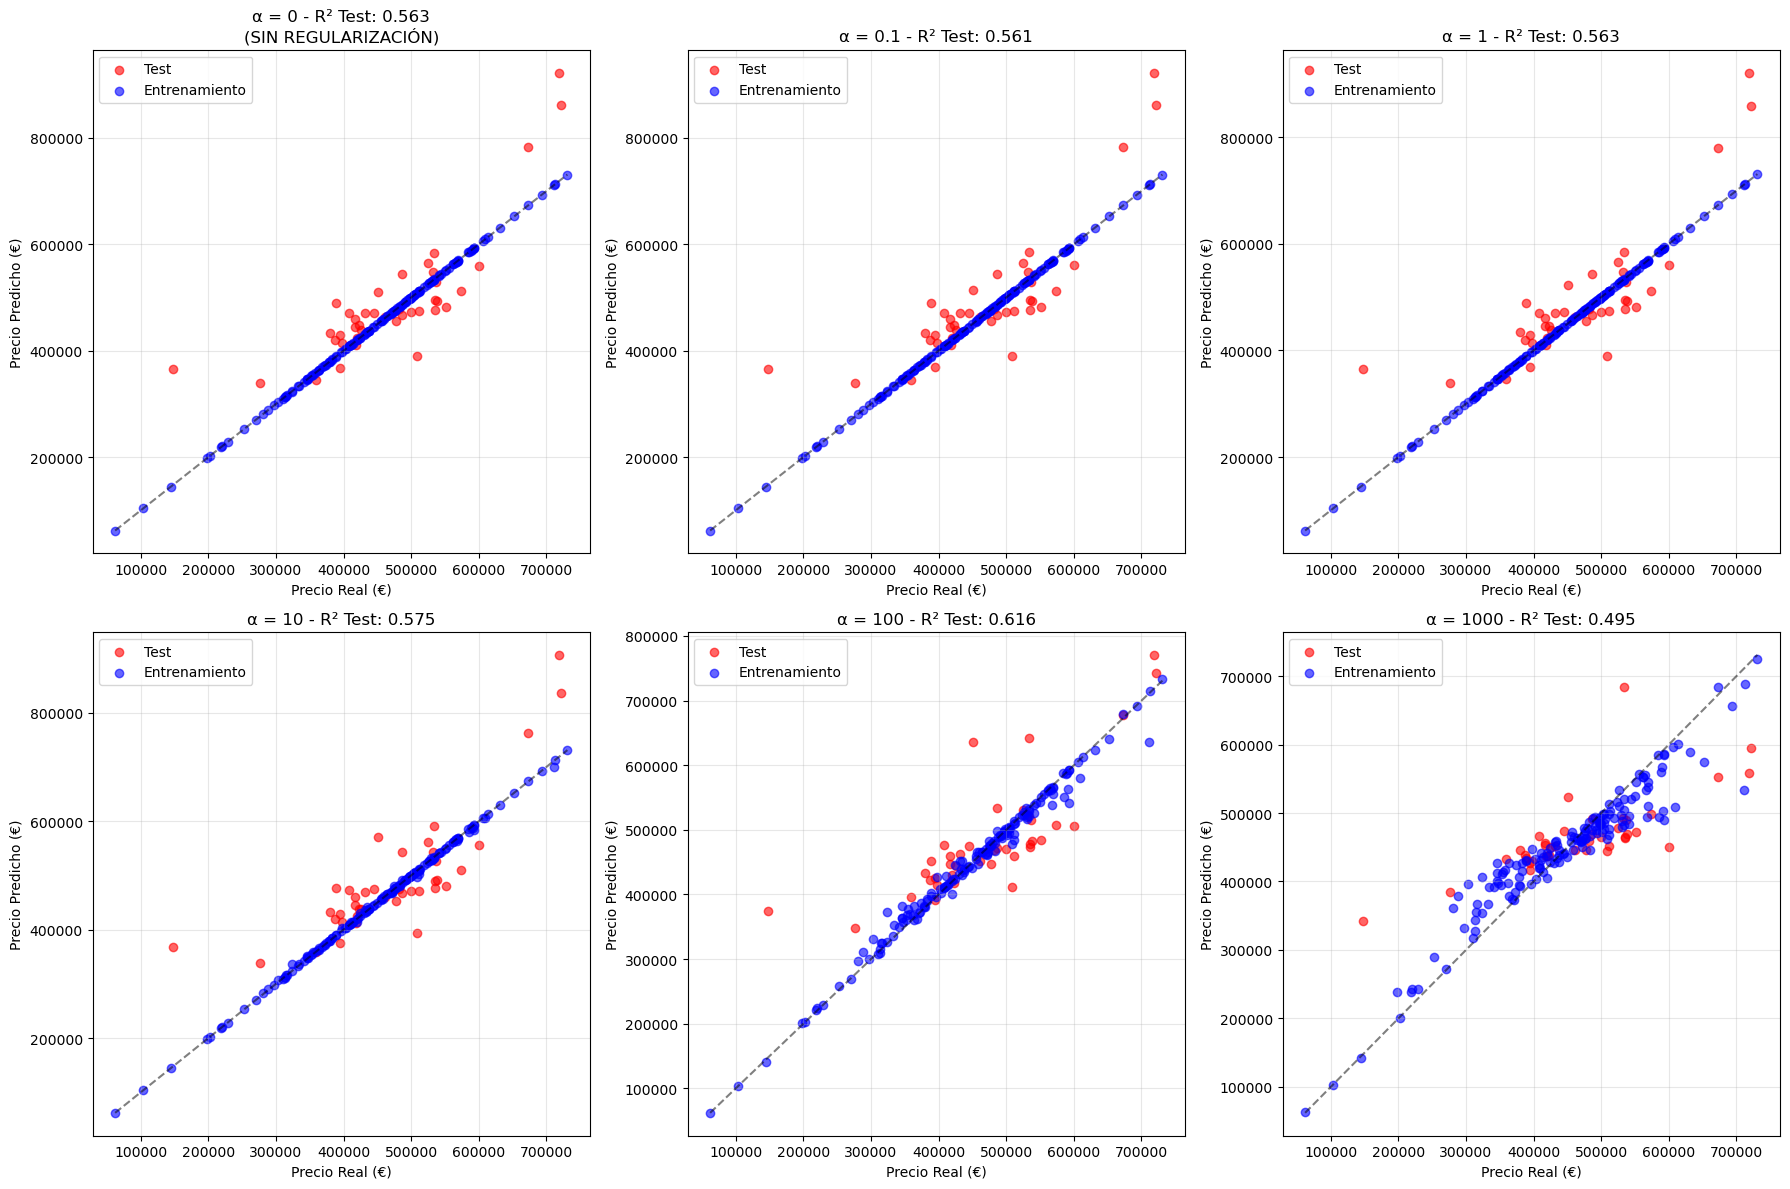


=== BÚSQUEDA DEL ALPHA ÓPTIMO ===
Alpha óptimo encontrado: 0.0010
MSE de validación mínimo: 12612842198

=== COMPARACIÓN RIDGE VS LASSO ===
Modelo		Train MSE	Test MSE	Train R²	Test R²
------------------------------------------------------------
Ridge		0	4908651079	1.000	0.561
Lasso		31008	2579801361	1.000	0.769

=== SIMULACIÓN DE EARLY STOPPING ===


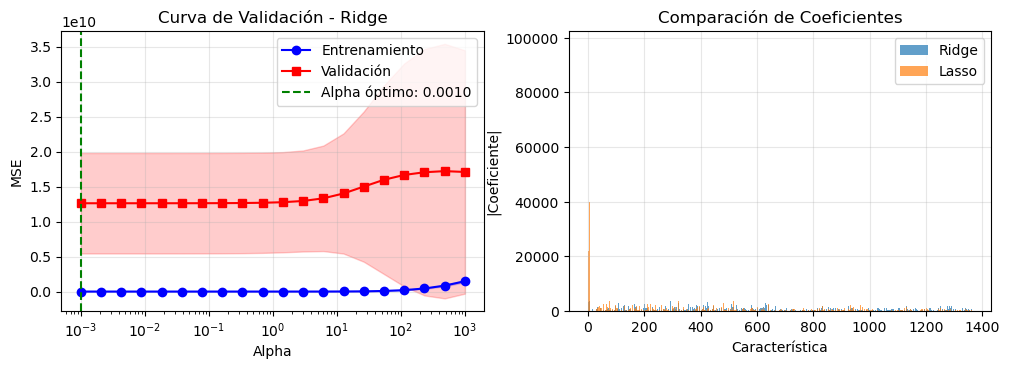

In [11]:
#APLICACIÓN DE REGULARIZACIÓN
print("\n=== APLICACIÓN DE REGULARIZACIÓN ===")
print("Usaremos el modelo de grado 4 (sobreajustado) y aplicaremos regularización")

# Definir modelo con características polinomiales de grado 4
degree = 4
poly_features = PolynomialFeatures(degree=degree)
X_train_poly = poly_features.fit_transform(X_train_scaled)
X_test_poly = poly_features.transform(X_test_scaled)

print(f"Características expandidas: {X_train_poly.shape[1]} (de {X_train_scaled.shape[1]} originales)")

# Probar diferentes valores de regularización
alphas = [0, 0.1, 1, 10, 100, 1000]
regularization_results = {}

print("\nAlpha\tTrain MSE\tTest MSE\tTrain R²\tTest R²\tDiferencia MSE")
print("-" * 80)

for alpha in alphas:
    if alpha == 0:
        model = LinearRegression()
        model_name = "Sin regularización"
    else:
        model = Ridge(alpha=alpha)
        model_name = f"Ridge α={alpha}"
    
    result = evaluate_model(model, X_train_poly, y_train, X_test_poly, y_test, model_name)
    regularization_results[alpha] = result
    
    diff_mse = result['test_mse'] - result['train_mse']
    status = "SIN REG" if alpha == 0 else "L2 REG"
    print(f"{alpha}\t{result['train_mse']:.0f}\t{result['test_mse']:.0f}\t{result['train_r2']:.3f}\t{result['test_r2']:.3f}\t{diff_mse:.0f}\t{status}")

#VISUALIZACIÓN DEL EFECTO DE LA REGULARIZACIÓN
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for i, alpha in enumerate(alphas):
    ax = axes[i]
    result = regularization_results[alpha]
    
    # Scatter plot: predicción vs real
    ax.scatter(y_test, result['y_test_pred'], alpha=0.6, label='Test', color='red')
    ax.scatter(y_train, result['y_train_pred'], alpha=0.6, label='Entrenamiento', color='blue')
    
    # Línea perfecta
    min_price = min(y_train.min(), y_test.min())
    max_price = max(y_train.max(), y_test.max())
    ax.plot([min_price, max_price], [min_price, max_price], 'k--', alpha=0.5)
    
    ax.set_xlabel('Precio Real (€)')
    ax.set_ylabel('Precio Predicho (€)')
    
    title = f'α = {alpha} - R² Test: {result["test_r2"]:.3f}'
    if alpha == 0:
        title += '\n(SIN REGULARIZACIÓN)'
    
    ax.set_title(title)
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#CURVA DE VALIDACIÓN PARA ENCONTRAR ALPHA ÓPTIMO
print("\n=== BÚSQUEDA DEL ALPHA ÓPTIMO ===")

alphas_range = np.logspace(-3, 3, 20)
train_scores, val_scores = validation_curve(
    Ridge(), X_train_poly, y_train,
    param_name='alpha', param_range=alphas_range,
    cv=5, scoring='neg_mean_squared_error'
)

train_mse = -train_scores.mean(axis=1)
val_mse = -val_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
val_std = val_scores.std(axis=1)

# Encontrar el alpha óptimo
optimal_alpha_idx = np.argmin(val_mse)
optimal_alpha = alphas_range[optimal_alpha_idx]

print(f"Alpha óptimo encontrado: {optimal_alpha:.4f}")
print(f"MSE de validación mínimo: {val_mse[optimal_alpha_idx]:.0f}")

# Visualización de la curva de validación
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.semilogx(alphas_range, train_mse, 'o-', label='Entrenamiento', color='blue')
plt.fill_between(alphas_range, train_mse - train_std, train_mse + train_std, alpha=0.2, color='blue')
plt.semilogx(alphas_range, val_mse, 's-', label='Validación', color='red')
plt.fill_between(alphas_range, val_mse - val_std, val_mse + val_std, alpha=0.2, color='red')
plt.axvline(optimal_alpha, color='green', linestyle='--', label=f'Alpha óptimo: {optimal_alpha:.4f}')
plt.xlabel('Alpha')
plt.ylabel('MSE')
plt.title('Curva de Validación - Ridge')
plt.legend()
plt.grid(True, alpha=0.3)

# 8. COMPARACIÓN CON LASSO
print("\n=== COMPARACIÓN RIDGE VS LASSO ===")

# Entrenar modelos finales
ridge_optimal = Ridge(alpha=optimal_alpha)
lasso_optimal = Lasso(alpha=optimal_alpha)

ridge_result = evaluate_model(ridge_optimal, X_train_poly, y_train, X_test_poly, y_test, 'Ridge')
lasso_result = evaluate_model(lasso_optimal, X_train_poly, y_train, X_test_poly, y_test, 'Lasso')

print("Modelo\t\tTrain MSE\tTest MSE\tTrain R²\tTest R²")
print("-" * 60)
print(f"Ridge\t\t{ridge_result['train_mse']:.0f}\t{ridge_result['test_mse']:.0f}\t{ridge_result['train_r2']:.3f}\t{ridge_result['test_r2']:.3f}")
print(f"Lasso\t\t{lasso_result['train_mse']:.0f}\t{lasso_result['test_mse']:.0f}\t{lasso_result['train_r2']:.3f}\t{lasso_result['test_r2']:.3f}")

# Comparar coeficientes
ridge_coefs = np.abs(ridge_optimal.coef_)
lasso_coefs = np.abs(lasso_optimal.coef_)

plt.subplot(2, 2, 2)
plt.bar(range(len(ridge_coefs)), ridge_coefs, alpha=0.7, label='Ridge')
plt.bar(range(len(lasso_coefs)), lasso_coefs, alpha=0.7, label='Lasso')
plt.xlabel('Característica')
plt.ylabel('|Coeficiente|')
plt.title('Comparación de Coeficientes')
plt.legend()
plt.grid(True, alpha=0.3)

#EARLY STOPPING SIMULATION
print("\n=== SIMULACIÓN DE EARLY STOPPING ===")

def early_stopping_simulation(X_train, y_train, X_val, y_val, patience=3):
    """Simula early stopping variando alpha"""
    
    alphas = np.logspace(-4, 2, 100)
    train_errors = []
    val_errors = []
    
    best_val_error = float('inf')
    patience_counter = 0
    best_alpha = None
    
    for alpha in alphas:
        model = Ridge(alpha=alpha)
        model.fit(X_train, y_train)
        
        train_pred = model.predict(X_train)
        val_pred = model.predict(X_val)
        
        train_error = mean_squared_error(y_train, train_pred)
        val_error = mean_squared_error(y_val, val_pred)
        
        train_errors.append(train_error)
        val_errors.append(val_error)
        
        if val_error < best_val_error:
            best_val_error = val_error
            best_alpha = alpha
            patience_counter = 0
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            print(f"Early stopping en iteración {len(train_errors)}")
            print(f"Mejor alpha: {best_alpha:.6f}")
            break
    
    return best_alpha, train_errors, val_errors, alphas[:len(train_errors)]

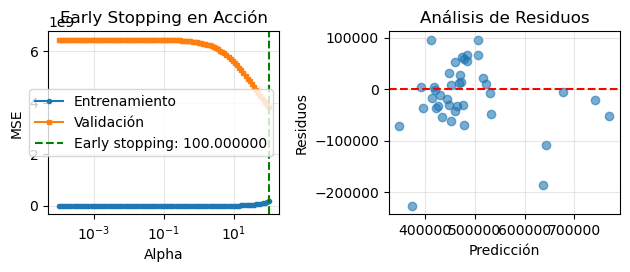


=== RESULTADOS FINALES ===
Modelo final (Ridge con α=100.000000):
- MSE en test: 4293280522
- R² en test: 0.616
- Error promedio: ±€65523

El modelo utilizó 1365 características derivadas
de las 11 características originales

=== EJEMPLOS DE PREDICCIONES ===
Real		Predicción	Error
----------------------------------------
€276,255	€347,607	€71,351
€445,407	€475,275	€29,868
€416,757	€447,627	€30,869
€395,001	€391,302	€3,699
€431,676	€463,277	€31,601


In [12]:

# Dividir datos de entrenamiento para early stopping
X_train_es, X_val_es, y_train_es, y_val_es = train_test_split(
    X_train_poly, y_train, test_size=0.2, random_state=42
)

best_alpha_es, train_errs, val_errs, alphas_used = early_stopping_simulation(
    X_train_es, y_train_es, X_val_es, y_val_es
)

plt.subplot(2, 2, 3)
plt.semilogx(alphas_used, train_errs, 'o-', label='Entrenamiento', markersize=3)
plt.semilogx(alphas_used, val_errs, 's-', label='Validación', markersize=3)
plt.axvline(best_alpha_es, color='green', linestyle='--', label=f'Early stopping: {best_alpha_es:.6f}')
plt.xlabel('Alpha')
plt.ylabel('MSE')
plt.title('Early Stopping en Acción')
plt.legend()
plt.grid(True, alpha=0.3)

# 10. ANÁLISIS DE RESIDUOS
final_model = Ridge(alpha=best_alpha_es)
final_model.fit(X_train_poly, y_train)
y_pred_final = final_model.predict(X_test_poly)

residuals = y_test - y_pred_final

plt.subplot(2, 2, 4)
plt.scatter(y_pred_final, residuals, alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicción')
plt.ylabel('Residuos')
plt.title('Análisis de Residuos')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 11. RESULTADOS FINALES
print("\n=== RESULTADOS FINALES ===")
final_mse = mean_squared_error(y_test, y_pred_final)
final_r2 = r2_score(y_test, y_pred_final)

print(f"Modelo final (Ridge con α={best_alpha_es:.6f}):")
print(f"- MSE en test: {final_mse:.0f}")
print(f"- R² en test: {final_r2:.3f}")
print(f"- Error promedio: ±€{np.sqrt(final_mse):.0f}")

# Análisis de importancia de características (simulado)
feature_names = ['area', 'bedrooms', 'bathrooms', 'age', 'distance_center', 
                'garage', 'garden', 'floors', 'house_number', 'street_width', 'neighbor_cats']

print(f"\nEl modelo utilizó {len(final_model.coef_)} características derivadas")
print(f"de las {len(feature_names)} características originales")

# Mostrar algunas predicciones ejemplo
print("\n=== EJEMPLOS DE PREDICCIONES ===")
print("Real\t\tPredicción\tError")
print("-" * 40)
for i in range(5):
    real = y_test.iloc[i]
    pred = y_pred_final[i]
    error = abs(real - pred)
    print(f"€{real:,.0f}\t€{pred:,.0f}\t€{error:,.0f}")
